In [2]:
import numpy as np
import GPy
import matplotlib.pyplot as plt


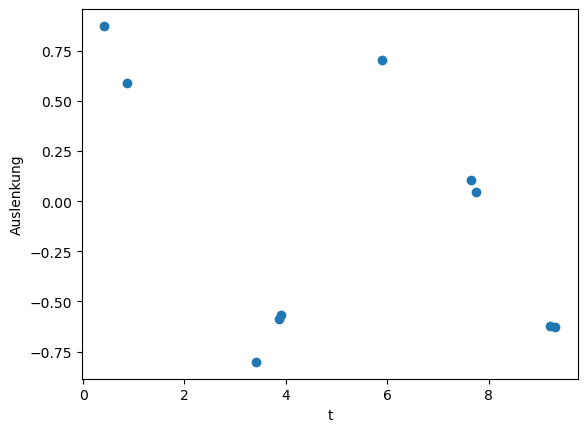

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def damped_harmonic_oscillator_analytical(m, b, k, y0, v0, t):
    omega = np.sqrt(k / m - (b / (2 * m))**2)
    A = np.sqrt(y0**2 + ((v0 + b * y0 / (2 * m)) / omega)**2)
    phi = np.arctan2((v0 + b * y0 / (2 * m)) / omega, y0)
    y = A * np.exp(-b * t / (2 * m)) * np.cos(omega * t + phi)
    return y

# Parameters
m = 1.0       # Mass
b = 0.1       # Damping coefficient
k = 1.0       # Spring constant
y0 = 1.0      # Initial displacement
v0 = 0.0      # Initial velocity
t = np.linspace(0, 10, 1000)  # Time range

# Calculate the analytical solution
y_analytical = damped_harmonic_oscillator_analytical(m, b, k, y0, v0, t)

#get 10 random points
random_numbers = np.random.randint(0,len(y_analytical),10)

t_training_data = t[random_numbers]
y_training_data = y_analytical[random_numbers]
plt.scatter(t_training_data, y_training_data)
plt.ylabel("Auslenkung")
plt.xlabel("t")

noise = 0.05
random_numbers_test_data = np.random.randint(0,len(y_analytical),100)
t_test_data = t[random_numbers_test_data].reshape(-1,1)
y_test_data = y_analytical[random_numbers_test_data] #* noise


In [1]:
t_training_data = t_training_data.reshape(-1,1)
y_training_data = y_training_data.reshape(-1,1)

kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(t_training_data, y_training_data, kernel)
m.Gaussian_noise.variance = noise
m.Gaussian_noise.variance.fix()
m.optimize(messages=True)
m.plot()

NameError: name 't_training_data' is not defined

In [25]:
def kernel(X1, X2, l=1.0, sigma_f_sq=1.0):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        (m x n) matrix.
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f_sq**2 * np.exp(-0.5 / l**2 * sqdist)

In [30]:
def changed_kernel(X1, X2, l=1.0, sigma_f_sq=1.0, m=1, b=1, k=1):
    #physics informed kernel
    dist = np.linalg.norm(X1-X2)
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    
    exponential_term =  sigma_f_sq**2 * np.exp(-0.5 / l**2 * sqdist)
    first_term = l**8 * dist**4
    second_term = -6*l**6*dist**2
    third_term = 3*l**4
    first_part = (first_term + second_term + third_term) * exponential_term * m

    #part with first derivative
    fist_term2 = l**2
    second_term2 = -l**4 * sqdist
    second_part = (fist_term2 + second_term2) * exponential_term * b

    #part with no derivative
    third_part = k * exponential_term

    return first_part + second_part + third_part

kernell = kernel(t_training_data, t_training_data)
kernel2 = changed_kernel(t_training_data, t_training_data)


In [31]:
from regresssion import posterior_distribution, marg_log_likelihood, grad_marg_log_likelihood, rbf_kernel
mean, var = posterior_distribution(t_training_data, y_training_data, t_test_data, kernel)
mean2, var2 = posterior_distribution(t_training_data, y_training_data, t_test_data, changed_kernel)

ValueError: operands could not be broadcast together with shapes (10,1) (100,1) 